# 이미지 데이터 불러오기

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd

BATCH_SIZE = 8
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

data_path = os.path.abspath('data')
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
validation_path = os.path.join(data_path, 'validation')

train_df = pd.read_csv(os.path.join(train_path, 'index.csv'))
test_df = pd.read_csv(os.path.join(test_path, 'index.csv'))
validation_df = pd.read_csv(os.path.join(validation_path, 'index.csv'))

train_flow_gen = train_gen.flow_from_dataframe(dataframe=train_df, directory=train_path, x_col='path', y_col='z', target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True, seed=124)
val_flow_gen = val_gen.flow_from_dataframe(dataframe=validation_df, directory=validation_path, x_col='path', y_col='z', target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True, seed=124)
test_flow_gen = test_gen.flow_from_dataframe(dataframe=test_df, directory=test_path, x_col='path', y_col='z', target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True, seed=124)

Found 8 validated image filenames.
Found 8 validated image filenames.
Found 7 validated image filenames.


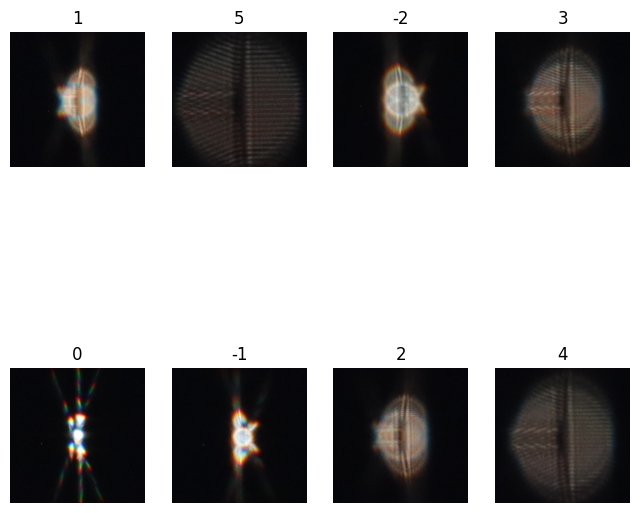

In [2]:
import matplotlib.pyplot as plt
import numpy as np

img, label = next(train_flow_gen)

plt.figure(figsize=(8, 8))
for i in range(8):
  ax = plt.subplot(2, 4, i+1)
  plt.imshow(img[i].astype(np.uint8))
  plt.title(label[i])
  plt.axis('off')

plt.show()

# 데이터 증강 레이어

In [3]:
from keras import Sequential, layers

data_aug = Sequential([
    layers.RandomFlip(),
    layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    layers.RandomRotation(1, fill_mode='nearest'),
    layers.RandomZoom(0.2, fill_mode='nearest'),
    layers.RandomContrast(0.2)
])

# ResNet152V2 기반 전이 학습 모델 구성

In [4]:
from keras.applications import resnet_v2

preprocess_input = resnet_v2.preprocess_input
base_model = resnet_v2.ResNet152V2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [5]:
from keras import Input, Model

base_model.trainable = False

inputs = Input(shape=IMG_SHAPE)
x = data_aug(inputs)
x = preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1)(x)

model = Model(inputs, outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [7]:
from keras.optimizers import Adam, RMSprop
from keras.losses import mean_squared_error, mean_absolute_error

model.compile(optimizer=Adam(learning_rate=1e-4), loss=mean_squared_error, metrics=['mae'])

In [8]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [9]:
history = model.fit(train_flow_gen, epochs=30, validation_data=val_flow_gen, callbacks=[early_stopping])

Epoch 1/30
1/1 [==============================] - 19s 19s/step - loss: 5.5385 - mae: 2.0628 - val_loss: 5.0325 - val_mae: 2.1587
Epoch 2/30
1/1 [==============================] - 0s 289ms/step - loss: 6.2296 - mae: 2.2041 - val_loss: 4.9369 - val_mae: 2.1387
Epoch 3/30
1/1 [==============================] - 0s 254ms/step - loss: 5.7802 - mae: 2.1798 - val_loss: 4.8423 - val_mae: 2.1184
Epoch 4/30
1/1 [==============================] - 0s 235ms/step - loss: 7.2472 - mae: 2.4435 - val_loss: 4.7516 - val_mae: 2.0987
Epoch 5/30
1/1 [==============================] - 0s 241ms/step - loss: 6.7033 - mae: 2.4107 - val_loss: 4.6614 - val_mae: 2.0786
Epoch 6/30
1/1 [==============================] - 0s 223ms/step - loss: 6.9244 - mae: 2.2677 - val_loss: 4.5761 - val_mae: 2.0594
Epoch 7/30
1/1 [==============================] - 0s 230ms/step - loss: 5.6812 - mae: 1.9667 - val_loss: 4.4941 - val_mae: 2.0406
Epoch 8/30
1/1 [==============================] - 0s 227ms/step - loss: 7.8464 - mae: 2.450

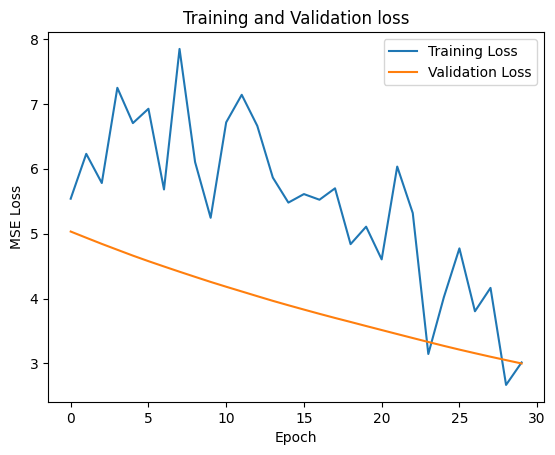

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation loss')
plt.show()

# 미세 조정(Fine-tuning)

In [11]:
base_model.trainable = True

for layer in base_model.layers[:-100]:
  layer.trainable = False

model.compile(optimizer=RMSprop(learning_rate=1e-5), loss=mean_squared_error, metrics=['mae'])

In [12]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [13]:
history_fine = model.fit(train_flow_gen, epochs=history.epoch[-1]+31, initial_epoch=history.epoch[-1]+1, validation_data=val_flow_gen, callbacks=[early_stopping, model_checkpoint])

Epoch 31/60
1/1 [==============================] - 26s 26s/step - loss: 5.8006 - mae: 2.0668 - val_loss: 2.5680 - val_mae: 1.4916
Epoch 32/60
1/1 [==============================] - 7s 7s/step - loss: 5.9538 - mae: 2.1197 - val_loss: 2.2113 - val_mae: 1.3690
Epoch 33/60
1/1 [==============================] - 5s 5s/step - loss: 5.8751 - mae: 2.0635 - val_loss: 1.9715 - val_mae: 1.2808
Epoch 34/60
1/1 [==============================] - 10s 10s/step - loss: 3.8795 - mae: 1.6152 - val_loss: 1.7871 - val_mae: 1.1946
Epoch 35/60
1/1 [==============================] - 10s 10s/step - loss: 4.1510 - mae: 1.7122 - val_loss: 1.7035 - val_mae: 1.1478
Epoch 36/60
1/1 [==============================] - 12s 12s/step - loss: 4.9225 - mae: 1.8774 - val_loss: 1.5407 - val_mae: 1.0807
Epoch 37/60
1/1 [==============================] - 10s 10s/step - loss: 3.8340 - mae: 1.6228 - val_loss: 1.4172 - val_mae: 1.0203
Epoch 38/60
1/1 [==============================] - 9s 9s/step - loss: 2.5426 - mae: 1.3356 - v

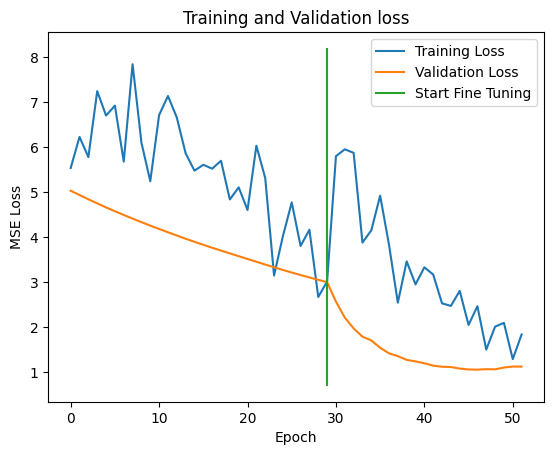

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation loss')
plt.show()

model.save('fine_tuning.h5')

# 시험 세트를 이용한 평가

In [15]:
images, labels = next(test_flow_gen)
model.load_weights('best_model.keras')
pred = model.predict(images).reshape(-1)
np.set_printoptions(suppress=True)
print(f'Predicted: {pred}')
print(f'Actual: {labels}')

1/1 [==============================] - 4s 4s/step
Predicted: [-1.1726891   3.3400636   0.8962934   2.3228707  -0.59869426  2.9055812
  5.0443954 ]
Actual: [-1  4  1  2  0  3  5]


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(f'MSE: {mean_squared_error(pred, labels)}, MAE: {mean_absolute_error(pred, labels)}')

MSE: 0.13566555096309937, MAE: 0.2852444733892168


Reference: [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)